In [1]:
%matplotlib inline
## imports

# site
from matplotlib import pyplot as plt
import numpy as np
import rasterio
import flopy

# std
from pathlib import Path
import yaml

In [2]:
def read_array(rasterfile, masked=True,  band=1):
    with rasterio.open(rasterfile) as src:
        return src.read(band, masked=masked)

In [3]:
def read_3d_array(rasterfiles, stack_axis=0, masked=True):
    arrays = []
    for rasterfile in rasterfiles:
        arrays.append(read_array(rasterfile, masked=masked))
    return np.ma.stack(arrays, axis=stack_axis)

In [4]:
data_dir = Path('../../mf6/data')

In [5]:
## input

# name
name = 'test_npf_brabant'

# workspace
workspace = Path(r'../output/npf')

# grid dimensions
nlay = 19
nrow = 450
ncol = 601
delr = 250.
delc = 250.

# data files
idomainfile = data_dir / 'boundary/IBOUND.tif'
topfile = str(data_dir / 'topbot/RL{ilay:}.tif')
botfile = str(data_dir / 'topbot/TH{ilay:}.tif')

In [6]:
# read idomain
idomain = read_array(idomainfile).filled(0.)
print(idomain.shape)

(450, 601)


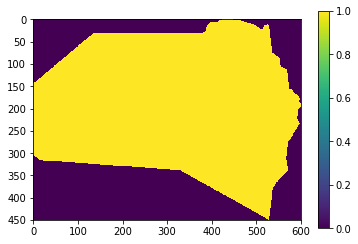

In [7]:
# show idomain
plt.imshow(idomain)
plt.colorbar()

In [8]:
# read tops
topfiles = (Path(topfile.format(ilay=i + 1)) for i in range(nlay))

tops = read_3d_array(topfiles)

# mask bad nodata values
tops = np.ma.masked_where(tops.mask | (tops < -9990.), tops)

# fill masked with zeros
tops = tops.filled(0.)

print(tops.shape)

(19, 450, 601)


In [9]:
# read bots
botfiles = (Path(botfile.format(ilay=i + 1)) for i in range(nlay))

bots = read_3d_array(botfiles)

# mask bad nodata values
bots = np.ma.masked_where(bots.mask | (bots < -9990.), bots)

# fill masked with zeros
bots = bots.filled(0.)

print(bots.shape)

(19, 450, 601)


In [10]:
# convert to top, botm
top = tops[0, :, :]
botm = []
for ilay in range(nlay):
    botm.append(bots[ilay, :, :])
    if (ilay + 1) < nlay:
        botm.append(tops[ilay + 1, :, :])
botm = np.ma.stack(botm)
print(botm.shape)

(37, 450, 601)


In [11]:
# idomain
idomain = np.broadcast_to(idomain, botm.shape)
print(idomain.shape)

(37, 450, 601)


In [12]:
kh = np.zeros(idomain.shape, dtype=np.float)
kv = np.zeros(idomain.shape, dtype=np.float)
for idx in range(botm.shape[0]):
    if idx == 0:
        t = top
    else:
        t = botm[idx-1, :, :]
    D = t - botm[idx, :, :]
    layer, sub_layer = divmod(idx, 2)
    if sub_layer == 0:
        kD_file = data_dir / f'kdc/TX{layer+1}.tif'
        kD = read_array(kD_file)
        
        kh[idx, :, :] = kD/D
        kv[idx, :, :] = 1e6
    else:
        c_file = data_dir / f'kdc/CL{layer+1}.tif'
        c = read_array(c_file)
        
        kh[idx, :, :] = 1e-6
        kv[idx, :, :] = D/c

In [13]:
# create workspace directory
workspace.mkdir(exist_ok=True)

In [14]:
# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name,
    exe_name='mf6', 
    version='mf6',
    sim_ws=str(workspace))

# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim,
    pname='tdis',
    time_units='DAYS',
    nper=1, 
    perioddata=[(1.0, 1, 1.0)],
    )

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = '{}.nam'.format(name)
gwf = flopy.mf6.ModflowGwf(sim,
    modelname=name, 
   model_nam_file=model_nam_file,
   )

In [15]:
# initialize the DIS package
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf,
    pname='dis', nlay=(nlay*2 - 1),
    nrow=nrow, ncol=ncol,
    delr=delr, delc=delc,
    top=top, botm=botm,
    idomain=idomain,
    )

In [16]:
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    model=gwf,
    save_flows=True,
    icelltype=1,
    k=kh,
    k22=kh,
    k33=kv
)

In [17]:
# write to package file
dis.write()
npf.write()

In [163]:
# attributes of dis package
print('NPF attributes:')
print('\n'.join(' - ' + a for a in dir(npf) if not a.startswith('_')))

NPF attributes:
 - alternative_cell_averaging
 - angle1
 - angle2
 - angle3
 - blocks
 - build_mfdata
 - container_type
 - create_package_dimensions
 - cvoptions
 - dfn
 - dfn_file_name
 - dimensions
 - filename
 - get_file_path
 - get_module
 - get_module_val
 - get_package
 - get_package_file_paths
 - icelltype
 - is_valid
 - k
 - k22
 - k33
 - last_error
 - load
 - loading_package
 - model_factory
 - model_name
 - name
 - package_abbr
 - package_dict
 - package_factory
 - package_key_dict
 - package_name
 - package_name_dict
 - package_names
 - package_type
 - package_type_dict
 - packagelist
 - parent_file
 - path
 - perched
 - post_block_comments
 - register_package
 - remove
 - rewet_record
 - save_flows
 - save_specific_discharge
 - set_model_relative_path
 - simulation_data
 - structure
 - thickstrt
 - type
 - wetdry
 - write
 - xt3doptions


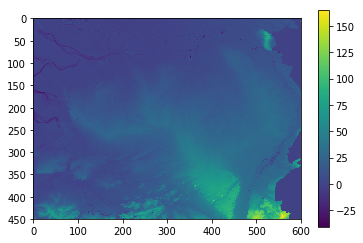

In [18]:
# show top
plt.imshow(dis.top.get_data())
plt.colorbar()

In [103]:
# show horizontal k
k_values_npf = np.ma.masked_where(idomain[::2, :, :] < 1, npf.k.get_data()[::2, :, :])
k_values_tri = read_3d_array([data_dir / f'kdc/px/PX{l+1}.tif' for l in range(nlay)])
k_values_diff = np.ma.masked_where(idomain[::2, :, :] < 1, (k_values_npf - k_values_tri))
#                                  (data_dir / f'kdc/py/PY{l+1}.tif' for l in range(nlay-1))))

In [154]:
print(f'{np.sum(k_values_diff != 0) / k_values_diff.count() * 100:.4f}% non-zero diffs (max absolute diff: {np.abs(k_values_diff).max()})')

0.0045% non-zero diffs (max absolute diff: 1.5209999660030007)


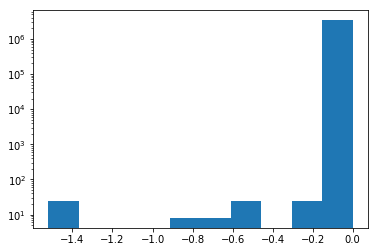

In [105]:
plt.hist(k_values_diff.flatten(), log=True);

In [113]:
# show horizontal k
kv_values_npf = np.ma.masked_where(idomain[1::2, :, :] < 1, npf.k33.get_data()[1::2, :, :])
kv_values_tri = np.ma.masked_where(idomain[1::2, :, :] < 1, read_3d_array([data_dir / f'kdc/py/PY{l+1}.tif' for l in range(nlay-1)]))
kv_values_diff = np.ma.masked_where(idomain[1::2, :, :] < 1, (kv_values_npf - kv_values_tri))

In [153]:
print(f'{np.sum(kv_values_diff != 0) / kv_values_diff.count() * 100:.4f}% non-zero diffs (max absolute diff: {np.abs(kv_values_diff).max()})')

0.0042% non-zero diffs (max absolute diff: 0.0107421875)


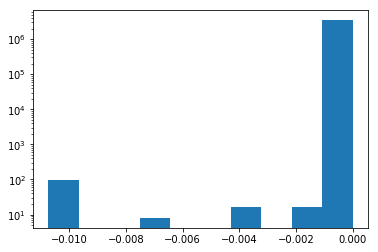

In [115]:
plt.hist(kv_values_diff.flatten(), log=True);

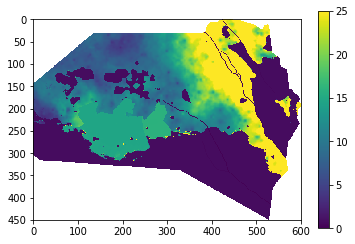

In [168]:
# show horizontal k
lay = 10
plt.imshow(k_values_npf[lay-1,:,:], vmin=0, vmax=25);
plt.colorbar();

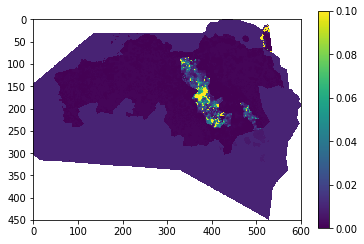

In [173]:
# show vertical k
lay = 3
plt.imshow(kv_values_npf[lay-1,:,:], vmin=0, vmax=.1);
plt.colorbar();